In [1]:
from fastai import *
from fastbook import *

#Getting the dataset
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path

Path('.')

In [2]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [3]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [5]:
#printing an image 
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [6]:
#converting the image into tensor 
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[0:27,0:27])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0


In [7]:
im3_t.shape

torch.Size([28, 28])

In [8]:
#Idea for first classifier (naive) 
#Get the "mean" of each digit and classify as the most similar one. 

#Creating list of tensors for data 
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

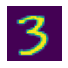

In [9]:
show_image(three_tensors[1])

In [10]:
#Stacking the tensors into 3D tensor and normalizing pixels. 
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens.shape

torch.Size([6265, 28, 28])

<AxesSubplot:>

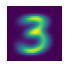

In [11]:
#mean of 3 
mean3 = stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

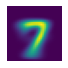

In [12]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

# How can we measure the difference between two pictures in this context ? 

Often we will take the mean of absolute values of differences between pixels (MAE == L1 NORM)) OR take the mean square of differences (RMSE == L2 NORM)

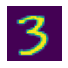

In [13]:
#Trying on a sample image 
a_3 = stacked_threes[1]
show_image(a_3);

In [14]:
#distance from threes
l1norm = (a_3 - mean3).abs().mean()
l2norm = ((a_3 - mean3)**2).mean().sqrt()
l1norm, l2norm

(tensor(0.1114), tensor(0.2021))

In [15]:
#distance from sevens 
l1norm = (a_3 - mean7).abs().mean()
l2norm = ((a_3 - mean7)**2).mean().sqrt()
l1norm, l2norm

(tensor(0.1586), tensor(0.3021))

In [16]:
#or use pytorch functions for it
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [17]:
#Creating a tensor 
data = [[1,2],[3,4]]

#Numpy array 
arr = array(data)

#Pytorch tensor 
tns = tensor(data)

In [18]:
tns

tensor([[1, 2],
        [3, 4]])

# Some data selections examples

Note: tensors work almost like np arrays

In [19]:
#row 
tns[1]

tensor([3, 4])

In [20]:
#col
tns[:,1]

tensor([2, 4])

In [21]:
#slice syntax 
tns[0:2,0:1]

tensor([[1],
        [3]])

# Using operations on tensors + choosing type

In [22]:
tns + 1

tensor([[2, 3],
        [4, 5]])

In [23]:
tns * 2

tensor([[2, 4],
        [6, 8]])

In [24]:
tns * tns

tensor([[ 1,  4],
        [ 9, 16]])

In [25]:
tns.type()

'torch.LongTensor'

In [26]:
#to float ? 
tns = tns.float()

In [27]:
tns.sqrt()

tensor([[1.0000, 1.4142],
        [1.7321, 2.0000]])

In [28]:
tns.mean()

tensor(2.5000)

In [29]:
tns.norm(1), tns.norm(2)

(tensor(10.), tensor(5.4772))

In [30]:
tns = tns.long()

In [31]:
tns

tensor([[1, 2],
        [3, 4]])

# Opening the validation data 

In [32]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [33]:
#write a function that returns the l1 norm. 
def l1(t1,t2):
    res = (t1-t2).abs().mean((-1,-2))
    return res 
l1(a_3, mean3)

tensor(0.1114)

In [34]:
#use that function on the tensors of valid to get results 
#We have a rank2 and rank 3 tensor. Pytorch uses broadcasting so it expends the smaller rank tensor to have same rank.
#This will make the computation possible even with different sizes of tensor !
valid_3_dist = l1(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1456, 0.1290, 0.1356,  ..., 0.1133, 0.1151, 0.1358]),
 torch.Size([1010]))

In [35]:
valid_3_tens.shape, mean3.shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]))

In [36]:
#Example of broadcasting 
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

In [37]:
#checking shape of operation, it will broadcast to rank
(tensor([1,2,3]) + tensor(1)).shape

torch.Size([3])

# Making the classifier function 

We can just use the distance function we created to see which one is more similar and then calculate the accuracies for each set ! 


In [38]:
def is_7(x):
    return l1(x, mean7) < l1(x, mean3)

#if this function is false, then predict 3

In [39]:
#Casting true tensor to float will convert it to a number 
tensor(True).float()

tensor(1.)

In [40]:
#Use this property to calculate the accuracy ! 
acc7 = is_7(valid_7_tens).float().mean()
acc7

tensor(0.9854)

In [41]:
acc3 = (1-is_7(valid_3_tens).float().mean())
acc3

tensor(0.9168)

# Stochastic Gradient Descent
Using SGD on a set of parameters ... 
For the example, we take x⁴ function as loss. The parameter is x. 
It is a toy example but doing it for multiple parameters is essentially the same. 

/home/lucien/anaconda3/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


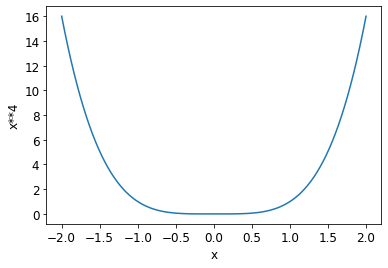

In [42]:
def f(x):
    return x**4
plot_function(f, 'x', 'x**4')

In [43]:
#init random param (2 for purpose of reproducibility)
param = torch.tensor(2).float().requires_grad_()
param

tensor(2., requires_grad=True)

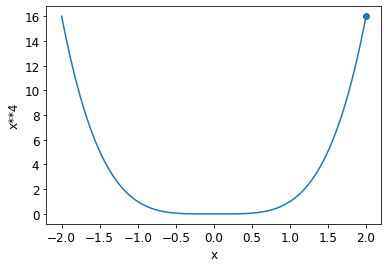

In [44]:
plot_function(f, 'x', 'x**4')
plt.scatter(param.detach().numpy(), f(param.detach().numpy()))

In [45]:
#Get gradient 
xt = param 
yt = f(xt)
yt.backward()
xt.grad

tensor(32.)

In [46]:
#Now do one step for param optimisation 
alpha = 0.01
xt.data = xt + (xt.grad * alpha * -1)
xt.grad = None #reset
xt

tensor(1.6800, requires_grad=True)

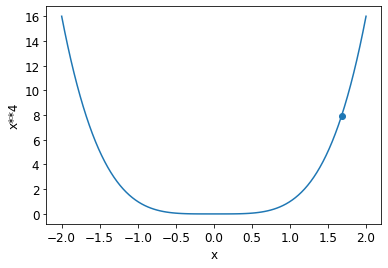

In [47]:
plot_function(f, 'x', 'x**4')
plt.scatter(xt.detach().numpy(), f(xt.detach().numpy()))

In [48]:
#function for a full step 
def step(param, alpha, render = False):
    #Do a whole step on the parameter 
    yt = f(param)
    yt.backward()
    grad = param.grad
    param.data = param - (alpha * grad)
    param.grad = None #reset gradient
    if render:
        plot_function(f, 'x', 'x**4')
        plt.scatter(param.detach().numpy(), f(param.detach().numpy()))
    print(param)
    
    

tensor(1.4903, requires_grad=True)
tensor(1.3579, requires_grad=True)
tensor(1.2578, requires_grad=True)
tensor(1.1782, requires_grad=True)
tensor(1.1128, requires_grad=True)
tensor(1.0576, requires_grad=True)
tensor(1.0103, requires_grad=True)
tensor(0.9691, requires_grad=True)
tensor(0.9327, requires_grad=True)
tensor(0.9002, requires_grad=True)
tensor(0.8710, requires_grad=True)
tensor(0.8446, requires_grad=True)
tensor(0.8205, requires_grad=True)
tensor(0.7984, requires_grad=True)
tensor(0.7780, requires_grad=True)
tensor(0.7592, requires_grad=True)
tensor(0.7417, requires_grad=True)
tensor(0.7254, requires_grad=True)
tensor(0.7101, requires_grad=True)
tensor(0.6958, requires_grad=True)
tensor(0.6823, requires_grad=True)
tensor(0.6696, requires_grad=True)
tensor(0.6576, requires_grad=True)
tensor(0.6462, requires_grad=True)
tensor(0.6354, requires_grad=True)
tensor(0.6252, requires_grad=True)
tensor(0.6154, requires_grad=True)
tensor(0.6061, requires_grad=True)
tensor(0.5972, requi

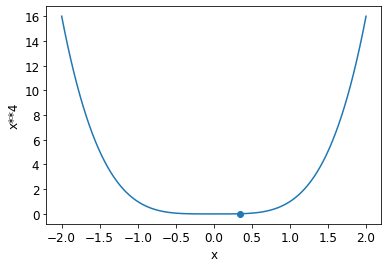

In [49]:
#Applying 100 steps 
for i in range(100):
    step(xt, alpha, False)
step(xt, alpha, True)

This shows exactly how parameter optimisation works with gradient descent. 

# Try it now with a function with multiple parameters for regression. 

In [50]:
#x 
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

In [51]:
#y 
speed = torch.randn(20).float() * 3 + 0.75*(time-9.5)**2 + 1
speed

tensor([74.4682, 59.6494, 45.8897, 26.3709, 21.4131, 19.4225, 12.5899, 10.7294,  3.7551, -0.8724, -0.2926,  3.4120,  4.9926, 10.3128, 15.4328, 26.2671, 31.7583, 42.0004, 57.5977, 66.8227])

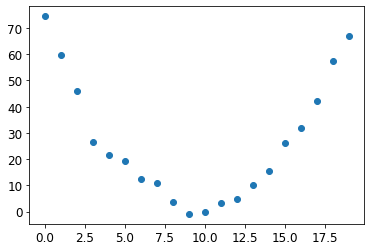

In [52]:
plt.scatter(time, speed)

In [53]:
#Function with all parameters 
def f(t, params): #params is a vector tensor 
    a, b, c = params
    return a*(t**2) + (b*t) + c

#mse 
def mse(preds, targets):
    return ((preds - targets)**2).mean().sqrt()


In [54]:
params =torch.randn(3).requires_grad_()
origin_parameters = params.clone()
preds = f(time, params)

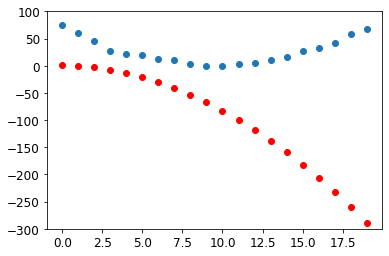

In [55]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)
show_preds(preds)

160.6978759765625


tensor([ 1.3526e+00, -1.6214e-01, -3.2052e+00, -7.7766e+00, -1.3876e+01, -2.1505e+01, -3.0661e+01, -4.1346e+01, -5.3559e+01, -6.7301e+01, -8.2571e+01, -9.9369e+01, -1.1770e+02, -1.3755e+02,
        -1.5893e+02, -1.8185e+02, -2.0629e+02, -2.3226e+02, -2.5975e+02, -2.8878e+02], grad_fn=<AddBackward0>)

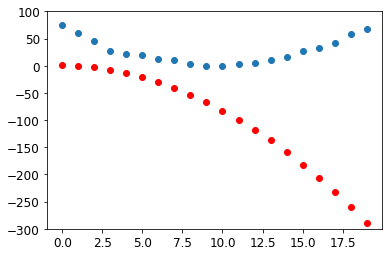

In [56]:
def step(params, alpha, show = False):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data = params - alpha * params.grad
    params.grad = None
    print(loss.item())
    preds = f(time, params)
    if show: 
        show_preds(preds)
    return preds

        #after one step
step(params, 0.00001, show = True)    

In [57]:
#do 999 steps 
for i in range(999):
    step(params, 0.00001, False)


160.42279052734375
160.14772033691406
159.87271118164062
159.59768676757812
159.3227081298828
159.04774475097656
158.7728271484375
158.4979248046875
158.22305297851562
157.9481964111328
157.67337036132812
157.39857482910156
157.12380981445312
156.84906005859375
156.5743408203125
156.29965209960938
156.02499389648438
155.75035095214844
155.4757537841797
155.201171875
154.92662048339844
154.65211486816406
154.37762451171875
154.1031494140625
153.82872009277344
153.55430603027344
153.27992248535156
153.0055694580078
152.73126220703125
152.4569549560547
152.18270874023438
151.90847778320312
151.63426208496094
151.36009216308594
151.08595275878906
150.81185913085938
150.5377655029297
150.26370239257812
149.9897003173828
149.7156982421875
149.44175720214844
149.16783142089844
148.89393615722656
148.6200714111328
148.3462371826172
148.0724334716797
147.79867553710938
147.52493286132812
147.25123596191406
146.97756958007812
146.7039337158203
146.43032836914062
146.15676879882812
145.8832397460

28.35125160217285
28.306867599487305
28.263225555419922
28.22032356262207
28.178144454956055
28.136680603027344
28.095928192138672
28.05587387084961
28.016508102416992
27.977825164794922
27.9398136138916
27.902463912963867
27.86577033996582
27.829721450805664
27.794307708740234
27.759519577026367
27.725353240966797
27.691795349121094
27.65884017944336
27.62647247314453
27.594694137573242
27.56348991394043
27.532852172851562
27.50277328491211
27.473243713378906
27.444255828857422
27.415800094604492
27.38787078857422
27.360462188720703
27.33355712890625
27.307153701782227
27.281246185302734
27.255823135375977
27.230878829956055
27.206403732299805
27.182390213012695
27.158828735351562
27.135717391967773
27.113048553466797
27.090808868408203
27.068994522094727
27.0476016998291
27.02661895751953
27.006040573120117
26.985857009887695
26.966068267822266
26.946659088134766
26.927631378173828
26.90896987915039
26.890676498413086
26.872737884521484
26.855154037475586
26.837913513183594
26.821010

26.018524169921875


tensor([ 1.3592,  0.8444,  0.6792,  0.8636,  1.3975,  2.2810,  3.5141,  5.0967,  7.0289,  9.3107, 11.9420, 14.9229, 18.2534, 21.9334, 25.9630, 30.3422, 35.0709, 40.1492, 45.5771, 51.3545],
       grad_fn=<AddBackward0>)

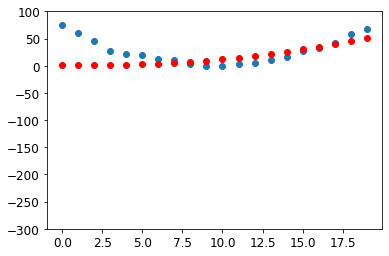

In [58]:
step(params, 0.00001, True)

# MNIST Loss 

In [59]:
#stacking train data
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [60]:
#assign labels 
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

# Creating dataset in pytorch 

!! It must return a tuple x, y when indexed, a simple way to create this under 

In [61]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [62]:
#valid set
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [63]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

# The function will assign a weight to each pixel, which is a parameter ! 


In [64]:
weights = init_params((28*28,1))

In [65]:
#adding a bias 
bias = init_params(1)

In [66]:
(train_x[0]*weights.T).sum() + bias #example prediction

tensor([20.2336], grad_fn=<AddBackward0>)

In [67]:
#To get predictions for every image in one operation, use matrix multiplication 
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

In [68]:
#Get result
corrects = (preds>0.5).float() == train_y
corrects.float().mean().item()

0.49080348014831543

# To use SGD here, we need a loss function. However accuracy can't be used because it won't be possible to get the gradients. 

The loss function receives the predictions from the model, not the image itself. (activation function !)

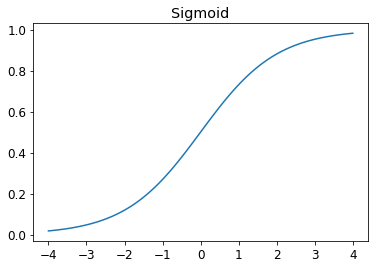

In [69]:
#Sigmoid activation function
def sigmoid(x): return 1/(1+torch.exp(-x))
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [70]:
def mnist_loss(predictions, targets): #loss for mnist using sigmoid
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

# Getting good convergence 
In order to have a good convervenge, we want to calculate the loss for some items. If we only take one it's not very good but if we take the average of all items it might be unstable. 

-> mini batch

In [71]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle = True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [72]:
#How to use a pytorch dataset to convert it into a dataloader
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [73]:
dl = DataLoader(ds, batch_size=5, shuffle = True)
list(dl)

[(tensor([17, 18, 10, 22,  8]), ('r', 's', 'k', 'w', 'i')),
 (tensor([14, 20, 15,  9, 13]), ('o', 'u', 'p', 'j', 'n')),
 (tensor([21, 12,  7, 25,  6]), ('v', 'm', 'h', 'z', 'g')),
 (tensor([ 5, 11, 23,  1,  3]), ('f', 'l', 'x', 'b', 'd')),
 (tensor([ 0, 24, 19, 16,  2]), ('a', 'y', 't', 'q', 'c')),
 (tensor([4]), ('e',))]

# Now doing a training loop over the dataset for SGD !

In [74]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [75]:
weights = init_params(28*28, 1)
bias = init_params(1)
dl = DataLoader(dset, batch_size = 256)
xb, yb = first(dl)
yb = yb.float()
xb.shape, yb.shape
#init params and load first batch

(torch.Size([256, 784]), torch.Size([256, 1]))

In [76]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [77]:
batch = train_x[:4]
preds = linear1(batch)
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7419, grad_fn=<MeanBackward0>)

In [78]:
batch, preds,preds.sigmoid(), train_y[:4]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([-2.1876, -8.3973,  2.5000, -4.9473], grad_fn=<AddBackward0>),
 tensor([1.0087e-01, 2.2543e-04, 9.2414e-01, 7.0524e-03], grad_fn=<SigmoidBackward>),
 tensor([[1],
         [1],
         [1],
         [1]]))

In [79]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784]), tensor(-0.0061), tensor([-0.0420]))

In [80]:
#create a function to get the gradiens 
def grad(a, b, model):
    preds = model(a) #a is train data, b is label
    loss = mnist_loss(preds, b)
    loss.backward()

# !! If we call backward() multiple times, instead of calculating gradient again it will ADD the new gradient to old one. We therefore need to reset it.

In [81]:
weights.grad.zero_()
bias.grad.zero_()
grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0061), tensor([-0.0420]))

# Clean MNIST optimisation with SGD

In [82]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

#create a function to get the gradiens 
def grad(xb, yb, model):
    preds = model(xb) #a is train data, b is label
    loss = mnist_loss(preds, yb)
    loss.backward()
    
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

    
###################################################
#training step 
def train_epoch(model, lr, params):
    for xb, yb in dl:
        grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()
            
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

##################################################          
#accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()
            

In [83]:
dset = list(zip(train_x, train_y))
dl = DataLoader(dset, batch_size=256)

In [84]:
#train epoch will calculate gradients and modify it for each batch in the dataset
alpha = 0.01
weights = torch.randn(28*28).float().requires_grad_()
bias = torch.randn(1).float().requires_grad_()
params = weights, bias
# epochs
for i in range(250):
    train_epoch(linear1, alpha, params)
    print(validate_epoch(linear1), end = ' ')

0.4268 0.4347 0.4444 0.4525 0.4579 0.4634 0.4686 0.4725 0.4782 0.4835 0.4883 0.4941 0.5004 0.5042 0.5091 0.5115 0.5154 0.5193 0.5248 0.5301 0.5364 0.5438 0.5474 0.551 0.5594 0.5708 0.5809 0.5937 0.6062 0.62 0.634 0.6519 0.6683 0.6831 0.6999 0.7119 0.7283 0.7399 0.7504 0.7642 0.7736 0.7824 0.7878 0.7957 0.803 0.8054 0.8132 0.8185 0.8225 0.8268 0.8332 0.8361 0.8395 0.8424 0.8454 0.8502 0.8521 0.855 0.8569 0.8578 0.8612 0.8651 0.867 0.868 0.8714 0.8734 0.8753 0.8772 0.8787 0.8796 0.8811 0.8835 0.8835 0.884 0.8854 0.8883 0.8898 0.8912 0.8922 0.8931 0.894 0.8949 0.8949 0.8954 0.8964 0.8978 0.8978 0.8983 0.8997 0.9001 0.9005 0.9015 0.9025 0.9035 0.9035 0.905 0.9059 0.9059 0.9059 0.9074 0.9089 0.9089 0.9099 0.9109 0.9109 0.9113 0.9113 0.9113 0.9113 0.9118 0.9123 0.9123 0.9128 0.9128 0.9143 0.9147 0.9152 0.9166 0.9166 0.9166 0.9166 0.9171 0.9176 0.9176 0.9181 0.9186 0.9191 0.9191 0.9186 0.9186 0.9186 0.9186 0.9191 0.9191 0.9195 0.92 0.9205 0.9205 0.9205 0.9205 0.9205 0.9205 0.9205 0.9205 0.920

# Creating an optimizer using pytorch functions

In [85]:
#change linear1 by pytorch lienar function 
linear_model = nn.Linear(28*28, 1)
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [86]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None
            

In [87]:
opt = BasicOptim(linear_model.parameters(), 0.01)

In [88]:
def train_epoch(model):
    for xb,yb in dl:
        grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [89]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [92]:
train_model(linear_model, 250)

0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9725 0.9729 0.9729 0.9729 0.9729 0.9729 0.9729 0.9729 0.9729 0.9729 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9734 0.9739 0.9739 0.9739 0.9739 0.9739 0.9739 0.9739 0.9739 0.9739 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9744 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9749 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754 0.9754

instead of using train_model, pytorch provides a .fit() function

In [93]:
linear_model = nn.Linear(28*28,1)

dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, linear_model, opt_func=SGD, loss_func = mnist_loss, metrics = batch_accuracy)

In [94]:
learn.fit(10, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.198346,0.367465,0.551521,00:00
1,0.116209,0.181345,0.876840,00:00
2,0.081899,0.108374,0.934249,00:00
3,0.065027,0.081284,0.949460,00:00
4,0.055696,0.067870,0.962218,00:00
5,0.049959,0.059925,0.963199,00:00
6,0.046079,0.054659,0.964671,00:00
7,0.043238,0.050895,0.965653,00:00
8,0.041030,0.048057,0.968106,00:00
9,0.039238,0.045827,0.969087,00:00


# Adding non-linearity in the parameter function 

In [95]:
#To add it we add a layer.
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [96]:
#In pytorch prog, if we add the activation function : 
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

#notice we only changed the model in this function 
learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.370803,0.396231,0.509323,00:00
1,0.166903,0.250319,0.783611,00:00
2,0.089420,0.121414,0.911678,00:00
3,0.056838,0.080236,0.939647,00:00
4,0.042081,0.062124,0.953386,00:00
5,0.034737,0.052114,0.962709,00:00
6,0.030620,0.045856,0.965653,00:00
7,0.027999,0.041598,0.967125,00:00
8,0.026138,0.038514,0.967615,00:00
9,0.024709,0.036177,0.968597,00:00


We are getting better accuracy now ! 

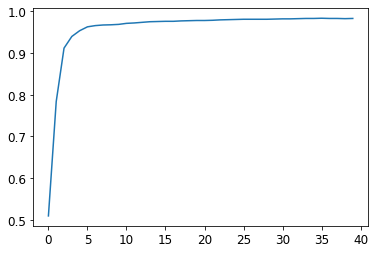

In [97]:
plt.plot(L(learn.recorder.values).itemgot(2));

# Note about number of layers 
It doesnt matter how many layers we use as long as we put activation functions between each layer... 
Under is the same approach with 18 layers. 

In [98]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.096229,0.016284,0.996565,00:09
